In [1]:
import pickle
import networkx as nx
from enum import Enum
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
import numpy as np
import random
import igraph as ig
import leidenalg as la
import community
from cdlib import algorithms
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'infomap', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


In [2]:
def convert(array_mapping):
    modularity_format = {}
    for i in range(len(array_mapping)):
        if not array_mapping[i] in modularity_format:
            modularity_format[array_mapping[i]] = [i]
        else:
            modularity_format[array_mapping[i]].append(i)
    
    return modularity_format.values()

In [29]:
class Dataset(Enum):
    CITHEPTHSGPT = "Directed Citation"
    SYMCITHEPTHSGPT = "Citation"
    SYNTHETIC6 = "Synthetic"
    SYNTHETIC10 = "Synthetic"
    PSYNTHETIC6 = "Synthetic + Pseudo-Edges"
    PSYNTHETIC10 = "Synthetic + Pseudo-Edges"
    PCITHEPTHSGPT = "Citation + Pseudo-Edges"
 
class Checkpoint:
   def __init__(self, dataset, algorithm, n_clusters, filename=None, data=None):
        self.dataset = dataset
        self.algorithm = algorithm
        self.n_clusters = n_clusters
        if filename:
            with open(filename, 'rb') as f:
                self.data = pickle.load(f)
        else:
            self.data = data
        try:
            self.data = self.data.numpy()
        except:
            None
        n_data = len(set(self.data))
        if self.n_clusters != n_data:
            print(f"!!! {self.algorithm} {self.dataset.value}: Number of clusters {self.n_clusters} does not match number of values in data, {n_data}.")
        self.n_clusters = n_data
        print(f"✓ Processed {self.algorithm} {self.dataset.value} ({self.n_clusters})")

In [30]:
def nmi(chkpt):
    if type(gnds[chkpt.dataset]) != type(None):
        return normalized_mutual_info_score(chkpt.data, gnds[chkpt.dataset])
    else:
        return "-"

def modularity(chkpt):
    A = As[chkpt.dataset]
    if chkpt.dataset == Dataset.PSYNTHETIC6:
        A = As[Dataset.SYNTHETIC6]
    elif chkpt.dataset == Dataset.PSYNTHETIC10:
        A = As[Dataset.SYNTHETIC10]
    elif chkpt.dataset == Dataset.PCITHEPTHSGPT:
        A = As[Dataset.SYMCITHEPTHSGPT]
        
    return nx.community.modularity(A, convert(chkpt.data), weight='weight', resolution=1)
    
def calculate_similarity(vector_1, vector_2):
    return np.dot(vector_1, vector_2) / (np.linalg.norm(vector_1)*np.linalg.norm(vector_2))

def calculate_intra_cluster_similarity(list_of_cluster_indices, attribute_matrix, percentage):
    n = len(list_of_cluster_indices)
    
    if n < 2:
        return 0.0  # Not enough nodes for similarity calculation
    
    cluster_indices_subset = np.random.choice(list_of_cluster_indices, size=int(percentage * n), replace=False)
    
    similarity = []
    
    for node_index1 in cluster_indices_subset:
        for node_index2 in cluster_indices_subset:
            if node_index1 < node_index2:
                similarity.append(calculate_similarity(attribute_matrix[node_index1], attribute_matrix[node_index2]))
    
    if len(similarity) > 0:
        return np.mean(similarity)
    else:
        return 0.0  # Return 0 if no pairs were investigated due to probability

def calculate_inter_cluster_similarity(list_of_cluster_indices1, list_of_cluster_indices2, attribute_matrix, percentage):
    similarity = []
    
    cluster_indices_subset1 = np.random.choice(list_of_cluster_indices1, size=int(percentage * len(list_of_cluster_indices1)), replace=False)
    cluster_indices_subset2 = np.random.choice(list_of_cluster_indices2, size=int(percentage * len(list_of_cluster_indices2)), replace=False)

    for first in cluster_indices_subset1:
        for second in cluster_indices_subset2:
            if random.random() < percentage:
                similarity.append(calculate_similarity(attribute_matrix[first], attribute_matrix[second]))
    
    if len(similarity) > 0:
        return np.mean(similarity)
    else:
        return 0.0  # Return 0 if no pairs were investigated due to probability

def calculate_intra_cluster_similarity_wrapper(communities, attribute_matrix, percentage):
    similarities = []
    for community in communities:
        similarities.append(calculate_intra_cluster_similarity(community, attribute_matrix, percentage))
    return np.mean(similarities)

def calculate_inter_cluster_similarity_wrapper(communities, attribute_matrix, percentage):
    similarities = []
    for index1, community1 in enumerate(communities):
        for index2, community2 in enumerate(communities):
            if index1 == index2:
                break
            similarities.append(calculate_inter_cluster_similarity(community1, community2, attribute_matrix, percentage))
    return np.mean(similarities)

def mean_and_std(fn, n=10):
    metric = [fn() for _ in range(n)]
    return f"{np.mean(metric).round(3)} ± {np.std(metric).round(3)}"
    
metrics = {
    "Inter-cluster Similarity": lambda chkpt: mean_and_std(lambda: calculate_inter_cluster_similarity_wrapper(convert(chkpt.data), attrs[chkpt.dataset], 0.1)) if len(set(chkpt.data)) < 2500 else "-",
    "Intra-cluster Similarity": lambda chkpt: mean_and_std(lambda: calculate_intra_cluster_similarity_wrapper(convert(chkpt.data), attrs[chkpt.dataset], 0.1)) if len(set(chkpt.data)) < 2500 else "-",
    "Modularity": modularity,
    "Normalized Mutual Information": nmi,
}

In [31]:
seed = 0
def detect_communities(G, attr, mode, sim_weighted=False, leiden_partition="Modularity Vertex Partition"):
    assert mode in ['louvain', 'leiden', 'infomap', 'k-core', 'best', 'infomap']
    n = max(G.nodes)
    edges = G.edges

    if sim_weighted:
        if mode != 'leiden':
            raise Exception("Mode not supported.")
        weights = {'weight': np.array([1+calculate_similarity(attr[e[0]], attr[e[1]]) for e in edges])}
        scale = 100
        weights['weight'] *= scale

    if mode == 'best':
        part = community.best_partition(G)
        values = [part.get(node) for node in G.nodes()]
        
    elif mode == 'louvain':
        part = nx.community.louvain_communities(G, seed=seed) # Array of dict for each community
        values = []
        
        for index, dic in enumerate(part):
            for k in range(len(dic)):
                values.append(index)
                    
    elif mode == 'leiden':
        if leiden_partition=="Modularity Vertex Partition":
            partition = la.ModularityVertexPartition
        elif leiden_partition=="CPM Vertex Partition":
            partition = la.CPMVertexPartition
        else:
            raise Exception("No/Unknown partition specified.")
        if sim_weighted:
            H = ig.Graph(n=n, edges=edges, edge_attrs=weights)
            part = la.find_partition(H, partition, weights=weights["weight"])
        else:
            H = ig.Graph.from_networkx(G)
            part = la.find_partition(H, partition)
        
        values = []
        value_dict = {}
              
        for i in range(len(part)):
              for j in part[i]:
                    value_dict[j] = i
        value_dict = dict(sorted(value_dict.items()))
        
        for value in value_dict.values():
            values.append(value)

    elif mode == 'infomap':
        H = ig.Graph.from_networkx(G)
        values = []

        part =  algorithms.infomap(G)
        part = part.to_node_community_map()  

        for value in part.values():
            values.append(value[0])            
    return values

In [32]:
As = {}
with open('/home/ecchan2/cs514-proj/snap_hepth/cit_hepth_adj_matrix.pkl', 'rb') as file:
    A = pickle.loads(file.read())
    As[Dataset.CITHEPTHSGPT] = nx.from_numpy_array(A)
    symmetric = A + A.T
    symmetric[symmetric > 1] = 1
    As[Dataset.SYMCITHEPTHSGPT] = nx.from_numpy_array(symmetric)
with open('/home/ecchan2/cs514-proj/dataset/cit_hepth_adj_pseudo_0.85_add.pkl', 'rb') as file:
    A = pickle.loads(file.read())
    # GCC does the preprocessing
    symmetric = A + A.T
    symmetric[symmetric > 1] = 1
    As[Dataset.PCITHEPTHSGPT] = nx.from_numpy_array(symmetric)
with open('/home/ecchan2/cs514-proj/challenging_adj_matrix.pkl', 'rb') as file:
    As[Dataset.SYNTHETIC6] = nx.from_numpy_array(pickle.loads(file.read()))
    As[Dataset.SYNTHETIC10] = As[Dataset.SYNTHETIC6]
with open('/home/ecchan2/cs514-proj/dataset/synthetic_adj_pseudo.pkl', 'rb') as file:
    As[Dataset.PSYNTHETIC6] = nx.from_numpy_array(pickle.loads(file.read()))
    As[Dataset.PSYNTHETIC10] = As[Dataset.SYNTHETIC6]
    
attrs = {}
with open('/home/ecchan2/cs514-proj/snap_hepth/cit_hepth_attributes_SGPT-125M-weightedmean-nli-bitfit.pkl', 'rb') as file:
    attrs[Dataset.CITHEPTHSGPT] = pickle.loads(file.read())
    attrs[Dataset.SYMCITHEPTHSGPT] = attrs[Dataset.CITHEPTHSGPT]
    attrs[Dataset.PCITHEPTHSGPT] = attrs[Dataset.CITHEPTHSGPT]
with open('/home/ecchan2/cs514-proj/challenging_attributes.pkl', 'rb') as file:
    attrs[Dataset.SYNTHETIC6] = pickle.loads(file.read())
    attrs[Dataset.SYNTHETIC10] = attrs[Dataset.SYNTHETIC6]
    attrs[Dataset.PSYNTHETIC6] = attrs[Dataset.SYNTHETIC6]
    attrs[Dataset.PSYNTHETIC10] = attrs[Dataset.SYNTHETIC6]
    
gnds = {}
gnds[Dataset.CITHEPTHSGPT] = None
gnds[Dataset.SYMCITHEPTHSGPT] = None
gnds[Dataset.PCITHEPTHSGPT] = None
with open('/home/ecchan2/cs514-proj/dataset/ground_truth_synthetic_6_clusters.pickle', 'rb') as file:
    gnds[Dataset.SYNTHETIC6] = np.array(pickle.loads(file.read()))
    gnds[Dataset.PSYNTHETIC6] = gnds[Dataset.SYNTHETIC6]
with open('/home/ecchan2/cs514-proj/dataset/ground_truth_synthetic_10_clusters.pickle', 'rb') as file:
    gnds[Dataset.SYNTHETIC10] = np.array(pickle.loads(file.read()))
    gnds[Dataset.PSYNTHETIC10] = gnds[Dataset.SYNTHETIC10]

In [33]:
chkpts = [
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "MCGC",
    #     173,
    #     "/home/ecchan2/cs514-proj/MCGC_modified_v3/ec/CitHepTh_SGPT_a10000-0_gamma-3_time0_epoch93_n_clusters_173_predict.pkl"
    # ),
    # Checkpoint(
    #     Dataset.SYNTHETIC6,
    #     "MCGC",
    #     6,
    #     "/home/ecchan2/cs514-proj/MCGC_modified_v3/ec/Synthetic_Challenging/Synthetic_Challenging_a10000-0_gamma-3_time0_epoch1_predict.pkl"
    # ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "Leiden (Modularity Partition)",
        10,
        data=detect_communities(As[Dataset.SYNTHETIC10], attrs[Dataset.SYNTHETIC10], 'leiden', leiden_partition="Modularity Vertex Partition"),
    ),
    Checkpoint(
        Dataset.PSYNTHETIC10,
        "Leiden (Modularity Partition)",
        10,
        data=detect_communities(As[Dataset.PSYNTHETIC10], attrs[Dataset.PSYNTHETIC10], 'leiden', leiden_partition="Modularity Vertex Partition")
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "Leiden (Modularity Partition; Similarity Weighted)",
        10,
        data=detect_communities(As[Dataset.SYNTHETIC10], attrs[Dataset.SYNTHETIC10], 'leiden', leiden_partition="Modularity Vertex Partition", sim_weighted=True),
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "Leiden (CPM Partition)",
        10,
        data=detect_communities(As[Dataset.SYNTHETIC10], attrs[Dataset.SYNTHETIC10], 'leiden', leiden_partition="CPM Vertex Partition"),
    ),
    Checkpoint(
        Dataset.PSYNTHETIC10,
        "Leiden (CPM Partition)",
        10,
        data=detect_communities(As[Dataset.PSYNTHETIC10], attrs[Dataset.PSYNTHETIC10], 'leiden', leiden_partition="CPM Vertex Partition")
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "Leiden (CPM Partition; Similarity Weighted)",
        10,
        data=detect_communities(As[Dataset.SYNTHETIC10], attrs[Dataset.SYNTHETIC10], 'leiden', leiden_partition="CPM Vertex Partition", sim_weighted=True),
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "GCC",
        6,
        "/home/ecchan2/cs514-proj/models/gcc_synthetic_6(1).pkl"
    ),
    Checkpoint(
        Dataset.PSYNTHETIC10,
        "GCC",
        6,
        "/home/ecchan2/cs514-proj/models/gcc_synthetic_pseudo_6.pkl"
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "GCC",
        10,
        "/home/ecchan2/cs514-proj/models/gcc_synthetic.pkl"
    ),
    Checkpoint(
        Dataset.PSYNTHETIC10,
        "GCC",
        10,
        "/home/ecchan2/cs514-proj/models/gcc_synthetic_pseudo.pkl"
    ),
    Checkpoint(
        Dataset.SYNTHETIC6,
        "GIC",
        6,
        "/home/ecchan2/cs514-proj/models/GIC_k_6_clustering_result.pickle"
    ),
    Checkpoint(
        Dataset.PSYNTHETIC6,
        "GIC",
        6,
        "/home/ecchan2/cs514-proj/models/GIC_k_6_clustering_result_pseudo_edge.pickle"
    ),
    Checkpoint(
        Dataset.SYNTHETIC6,
        "GIC (Semantic Loss)",
        6,
        "/home/ecchan2/cs514-proj/models/GIC_k_6_clustering_result_Semantic.pickle"
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "GIC",
        10,
        "/home/ecchan2/cs514-proj/models/GIC_k_10_clustering_result.pickle"
    ),
    Checkpoint(
        Dataset.PSYNTHETIC10,
        "GIC",
        10,
        "/home/ecchan2/cs514-proj/models/GIC_k_10_clustering_result_pseudo_edge.pickle"
    ),
    Checkpoint(
        Dataset.SYNTHETIC10,
        "GIC (Semantic Loss)",
        10,
        "/home/ecchan2/cs514-proj/models/GIC_k_10_clustering_result_Semantic.pickle"
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "Leiden (Modularity Partition)",
    #     173,
    #     data=detect_communities(As[Dataset.CITHEPTHSGPT], attrs[Dataset.CITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition")
    # ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "Leiden (Modularity Partition)",
        173,
        data=detect_communities(As[Dataset.SYMCITHEPTHSGPT], attrs[Dataset.SYMCITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition")
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "Leiden (Modularity Partition)",
        173,
        data=detect_communities(As[Dataset.PCITHEPTHSGPT], attrs[Dataset.PCITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition")
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "Leiden (Modularity Partition; Similarity Weighted)",
    #     173,
    #     data=detect_communities(As[Dataset.CITHEPTHSGPT], attrs[Dataset.CITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition", sim_weighted=True),
    # ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "Leiden (Modularity Partition; Similarity Weighted)",
        173,
        data=detect_communities(As[Dataset.SYMCITHEPTHSGPT], attrs[Dataset.SYMCITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition", sim_weighted=True),
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "Leiden (CPM Partition)",
    #     173,
    #     data=detect_communities(As[Dataset.CITHEPTHSGPT], attrs[Dataset.CITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition")
    # ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "Leiden (CPM Partition)",
        173,
        data=detect_communities(As[Dataset.SYMCITHEPTHSGPT], attrs[Dataset.SYMCITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition")
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "Leiden (CPM Partition)",
        173,
        data=detect_communities(As[Dataset.PCITHEPTHSGPT], attrs[Dataset.PCITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition")
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "Leiden (CPM Partition; Similarity Weighted)",
    #     173,
    #     data=detect_communities(As[Dataset.CITHEPTHSGPT], attrs[Dataset.CITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition", sim_weighted=True),
    # ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "Leiden (CPM Partition; Similarity Weighted)",
        173,
        data=detect_communities(As[Dataset.SYMCITHEPTHSGPT], attrs[Dataset.SYMCITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition", sim_weighted=True),
    ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GCC",
        173,
        "/home/ecchan2/cs514-proj/models/gcc_cit_hepth_sym.pkl"
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "GCC",
        173,
        "/home/ecchan2/cs514-proj/models/gcc_cit_hepth_pseudo_0.85_add.pkl"
    ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GCC",
        21,
        "/home/ecchan2/cs514-proj/models/gcc_cit_hepth_21.pkl"
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "GCC",
        21,
        "/home/ecchan2/cs514-proj/models/gcc_cit_hepth_pseudo_21(1).pkl"
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "GIC",
    #     173,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_k_173_alpha_0.5_beta_100.pickle"
    # ),
    # Checkpoint(
    #     Dataset.PCITHEPTHSGPT,
    #     "GIC",
    #     173,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_pseudo_k_173_alpha_0.25_beta_100.pickle"
    # ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "GIC (Semantic Loss)",
    #     173,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_loss_k_173_alpha_0.25_beta_10.pickle"
    # ),
    
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GIC",
        173,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_k_173_alpha_0.5_beta_100.pickle"
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "GIC",
        173,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_pseudo_k_173_alpha_0.25_beta_100.pickle"
    ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GIC (Semantic Loss)",
        173,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_loss_k_173_alpha_0.25_beta_10.pickle"
    ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "GIC",
    #     21,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_k_21_alpha_0.25_beta_10.pickle"
    # ),
    # Checkpoint(
    #     Dataset.PCITHEPTHSGPT,
    #     "GIC",
    #     21,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_pseudo_k_21_alpha_0.25_beta_100.pickle"
    # ),
    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "GIC (Semantic Loss)",
    #     21,
    #     "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_loss_k_21_alpha_0.75_beta_10.pickle"
    # ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GIC",
        21,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_k_21_alpha_0.25_beta_10.pickle"
    ),
    Checkpoint(
        Dataset.PCITHEPTHSGPT,
        "GIC",
        21,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_pseudo_k_21_alpha_0.25_beta_100.pickle"
    ),
    Checkpoint(
        Dataset.SYMCITHEPTHSGPT,
        "GIC (Semantic Loss)",
        21,
        "/home/ecchan2/cs514-proj/models/GIC_cit_hepth_loss_k_21_alpha_0.75_beta_10.pickle"
    ),



    # Checkpoint(
    #     Dataset.CITHEPTHSGPT,
    #     "GCC",
    #     173,
    #     "/home/ecchan2/cs514-proj/models/gcc_cit_hepth_173.pkl"
    # ),
    # Checkpoint(
    #     Dataset.PCITHEPTHSGPT,
    #     "Leiden (Modularity Partition; Similarity Weighted)",
    #     173,
    #     data=detect_communities(As[Dataset.PCITHEPTHSGPT], attrs[Dataset.PCITHEPTHSGPT], 'leiden', leiden_partition="Modularity Vertex Partition", sim_weighted=True)
    # ),
    # Checkpoint(
    #     Dataset.PCITHEPTHSGPT,
    #     "Leiden (CPM Partition; Similarity Weighted)",
    #     173,
    #     data=detect_communities(As[Dataset.PCITHEPTHSGPT], attrs[Dataset.PCITHEPTHSGPT], 'leiden', leiden_partition="CPM Vertex Partition", sim_weighted=True)
    # ),
    # Checkpoint(
    #     Dataset.PSYNTHETIC10,
    #     "Leiden (Modularity Partition; Similarity Weighted)",
    #     10,
    #     data=detect_communities(As[Dataset.PSYNTHETIC10], attrs[Dataset.PSYNTHETIC10], 'leiden', leiden_partition="Modularity Vertex Partition", sim_weighted=True),
    # ),
    # Checkpoint(
    #     Dataset.PSYNTHETIC10,
    #     "Leiden (CPM Partition; Similarity Weighted)",
    #     10,
    #     data=detect_communities(As[Dataset.PSYNTHETIC10], attrs[Dataset.PSYNTHETIC10], 'leiden', leiden_partition="CPM Vertex Partition", sim_weighted=True),
    # ),
]

✓ Processed Leiden (Modularity Partition) Synthetic (10)
✓ Processed Leiden (Modularity Partition) Synthetic + Pseudo-Edges (10)
✓ Processed Leiden (Modularity Partition; Similarity Weighted) Synthetic (10)
!!! Leiden (CPM Partition) Synthetic: Number of clusters 10 does not match number of values in data, 2001.
✓ Processed Leiden (CPM Partition) Synthetic (2001)
!!! Leiden (CPM Partition) Synthetic + Pseudo-Edges: Number of clusters 10 does not match number of values in data, 2001.
✓ Processed Leiden (CPM Partition) Synthetic + Pseudo-Edges (2001)
✓ Processed Leiden (CPM Partition; Similarity Weighted) Synthetic (10)
✓ Processed GCC Synthetic (6)
✓ Processed GCC Synthetic + Pseudo-Edges (6)
✓ Processed GCC Synthetic (10)
✓ Processed GCC Synthetic + Pseudo-Edges (10)
✓ Processed GIC Synthetic (6)
✓ Processed GIC Synthetic + Pseudo-Edges (6)
✓ Processed GIC (Semantic Loss) Synthetic (6)
✓ Processed GIC Synthetic (10)
✓ Processed GIC Synthetic + Pseudo-Edges (10)
✓ Processed GIC (Semanti

In [34]:
df = {
    "Dataset": [],
    "Algorithm": [],
    "Number of Clusters": [],
}
for metric in metrics:
    df[metric] = []

for i, chkpt in enumerate(chkpts):
    # if "CPM" in chkpt.algorithm:
    #     continue
    df["Dataset"].append(chkpt.dataset.value)
    df["Algorithm"].append(chkpt.algorithm)
    df["Number of Clusters"].append(chkpt.n_clusters)
    for metric_name, metric_fn in metrics.items():
        metric_value = metric_fn(chkpt)
        df[metric_name].append(metric_value)
    for k in df:
        print(k, df[k][-1])
    # print(f"{i} of {len(chkpts)}", end="\r")
        
print(len(chkpts), "experiments.")
pd.DataFrame(df).sort_values(["Dataset", "Algorithm", "Number of Clusters"]).reset_index(drop=True)

Dataset Synthetic
Algorithm Leiden (Modularity Partition)
Number of Clusters 10
Inter-cluster Similarity 0.022 ± 0.001
Intra-cluster Similarity 0.993 ± 0.0
Modularity 0.8278045431788428
Normalized Mutual Information 1.0
Dataset Synthetic + Pseudo-Edges
Algorithm Leiden (Modularity Partition)
Number of Clusters 10
Inter-cluster Similarity 0.022 ± 0.001
Intra-cluster Similarity 0.992 ± 0.0
Modularity 0.8278045431788428
Normalized Mutual Information 1.0
Dataset Synthetic
Algorithm Leiden (Modularity Partition; Similarity Weighted)
Number of Clusters 10
Inter-cluster Similarity 0.022 ± 0.001
Intra-cluster Similarity 0.992 ± 0.0
Modularity 0.8278045431788428
Normalized Mutual Information 1.0
Dataset Synthetic
Algorithm Leiden (CPM Partition)
Number of Clusters 2001
Inter-cluster Similarity 0.0 ± 0.0
Intra-cluster Similarity 0.0 ± 0.0
Modularity -0.0005569476153308089
Normalized Mutual Information 0.46390436875663243
Dataset Synthetic + Pseudo-Edges
Algorithm Leiden (CPM Partition)
Number of

,Dataset,Algorithm,Number of Clusters,Inter-cluster Similarity,Intra-cluster Similarity,Modularity,Normalized Mutual Information
0,Citation,GCC,21,0.17 ± 0.007,0.279 ± 0.005,0.183318,-
1,Citation,GCC,173,0.005 ± 0.0,0.041 ± 0.0,0.413184,-
2,Citation,GIC,21,0.566 ± 0.0,0.578 ± 0.002,0.071996,-
3,Citation,GIC,173,0.546 ± 0.002,0.598 ± 0.003,0.080100,-
4,Citation,GIC (Semantic Loss),21,0.567 ± 0.001,0.589 ± 0.002,0.114889,-
5,Citation,GIC (Semantic Loss),173,0.563 ± 0.0,0.613 ± 0.002,0.113006,-
6,Citation,Leiden (CPM Partition),27770,-,-,-0.000040,-
7,Citation,Leiden (CPM Partition; Similarity Weighted),1180,0.023 ± 0.0,0.117 ± 0.001,0.615057,-
8,Citation,Leiden (Modularity Partition),171,0.011 ± 0.0,0.076 ± 0.0,0.663743,-
9,Citation,Leiden (Modularity Partition; Similarity Weigh...,178,0.017 ± 0.0,0.087 ± 0.001,0.660400,-


In [35]:
data = pd.DataFrame(df)
columns = data.columns
for dataset, cols in zip([
    [Dataset.CITHEPTHSGPT.value, Dataset.SYMCITHEPTHSGPT.value, Dataset.PCITHEPTHSGPT.value],
    [Dataset.SYNTHETIC6.value, Dataset.SYNTHETIC10.value, Dataset.PSYNTHETIC6.value, Dataset.PSYNTHETIC10.value],
], [
    ["Algorithm", "Dataset", "Number of Clusters", "Inter-cluster Similarity", "Intra-cluster Similarity", "Modularity"],
    ["Algorithm", "Dataset", "Number of Clusters", "Inter-cluster Similarity", "Intra-cluster Similarity", "Modularity", "Normalized Mutual Information"],
]
):
    dataset_data = data[[v in dataset for v in data.Dataset]]
    display(dataset_data.sort_values(["Algorithm", "Dataset", "Number of Clusters"]).reset_index(drop=True)[cols])
    

# Citation Graph
    # GCC
        # Vanilla
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
        # Pseudo-Edges
            # PCITHEPTHSGPT
        # Modified Objective Function
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
    # GIC
        # Vanilla
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
        # Pseudo-Edges
            # PCITHEPTHSGPT
        # Modified Objective Function
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
            
    # Leiden (Modularity Partition)
        # Vanilla
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
        # Pseudo-Edges
            # PCITHEPTHSGPT
        # Similarity Weighted
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT

    # Leiden (CPM Partition)
        # Vanilla
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT
        # Pseudo-Edges
            # PCITHEPTHSGPT
        # Similarity Weighted
            # CITHEPTHSGPT
            # SYMCITHEPTHSGPT

# Synthetic
    # GCC
        # Vanilla
            # SYNTHETIC6
            # SYNTHETIC10
        # Pseudo-Edges
            # PSYNTHETIC6
            # PSYNTHETIC10
        # Modified Objective Function
            # SYNTHETIC6
            # SYNTHETIC10
    # GIC
        # Vanilla
            # SYNTHETIC6
            # SYNTHETIC10
        # Pseudo-Edges
            # PSYNTHETIC6
            # PSYNTHETIC10
        # Modified Objective Function
            # SYNTHETIC6
            # SYNTHETIC10

    # Leiden (Modularity Partition)
        # Vanilla
            # SYNTHETIC6
            # SYNTHETIC10
        # Pseudo-Edges
            # PSYNTHETIC6
            # PSYNTHETIC10
        # Similarity Weighted
            # SYNTHETIC6
            # SYNTHETIC10

    # Leiden (CPM Partition)
        # Vanilla
            # SYNTHETIC6
            # SYNTHETIC10
        # Pseudo-Edges
            # PSYNTHETIC6
            # PSYNTHETIC10
        # Similarity Weighted
            # SYNTHETIC6
            # SYNTHETIC10


,Algorithm,Dataset,Number of Clusters,Inter-cluster Similarity,Intra-cluster Similarity,Modularity
0,GCC,Citation,21,0.17 ± 0.007,0.279 ± 0.005,0.183318
1,GCC,Citation,173,0.005 ± 0.0,0.041 ± 0.0,0.413184
2,GCC,Citation + Pseudo-Edges,21,0.074 ± 0.007,0.196 ± 0.005,0.079040
3,GCC,Citation + Pseudo-Edges,173,0.016 ± 0.0,0.085 ± 0.001,0.428722
4,GIC,Citation,21,0.566 ± 0.0,0.578 ± 0.002,0.071996
5,GIC,Citation,173,0.546 ± 0.002,0.598 ± 0.003,0.080100
6,GIC,Citation + Pseudo-Edges,21,0.568 ± 0.001,0.58 ± 0.003,0.073583
7,GIC,Citation + Pseudo-Edges,173,0.564 ± 0.001,0.611 ± 0.002,0.101749
8,GIC (Semantic Loss),Citation,21,0.567 ± 0.001,0.589 ± 0.002,0.114889
9,GIC (Semantic Loss),Citation,173,0.563 ± 0.0,0.613 ± 0.002,0.113006


,Algorithm,Dataset,Number of Clusters,Inter-cluster Similarity,Intra-cluster Similarity,Modularity,Normalized Mutual Information
0,GCC,Synthetic,6,-0.198 ± 0.001,0.992 ± 0.001,0.713883,0.830619
1,GCC,Synthetic,10,-0.11 ± 0.001,0.992 ± 0.0,0.538608,0.747062
2,GCC,Synthetic + Pseudo-Edges,6,-0.199 ± 0.001,0.993 ± 0.0,0.714280,0.832397
3,GCC,Synthetic + Pseudo-Edges,10,0.022 ± 0.0,0.992 ± 0.0,0.827805,1.0
4,GIC,Synthetic,6,0.094 ± 0.05,0.191 ± 0.079,0.468920,0.554328
5,GIC,Synthetic,10,0.094 ± 0.037,0.111 ± 0.195,0.366612,0.509225
6,GIC,Synthetic + Pseudo-Edges,6,0.133 ± 0.036,0.24 ± 0.074,0.369697,0.532149
7,GIC,Synthetic + Pseudo-Edges,10,0.109 ± 0.032,0.226 ± 0.068,0.213982,0.473718
8,GIC (Semantic Loss),Synthetic,6,0.088 ± 0.058,0.179 ± 0.076,0.464257,0.553394
9,GIC (Semantic Loss),Synthetic,10,0.108 ± 0.044,0.089 ± 0.059,0.358271,0.506893


    X           Y                                             Method
0  10   23.801050                      Leiden (Modularity Partition)
1  10   23.801050  Leiden (Modularity Partition; Similarity Weigh...
2  10   23.801050        Leiden (CPM Partition; Similarity Weighted)
3   6  192.826995                                                GCC
4  10  134.483047                                                GCC
5   6  214.908314                                                GIC
6   6  232.889638                                GIC (Semantic Loss)
7  10  168.685180                                                GIC
8  10  177.801828                                GIC (Semantic Loss)
    X           Y                         Method
0  10   23.801050  Leiden (Modularity Partition)
1   6  192.479220                            GCC
2  10   23.801050                            GCC
3   6  109.423870                            GIC
4  10   74.326913                            GIC
     X          

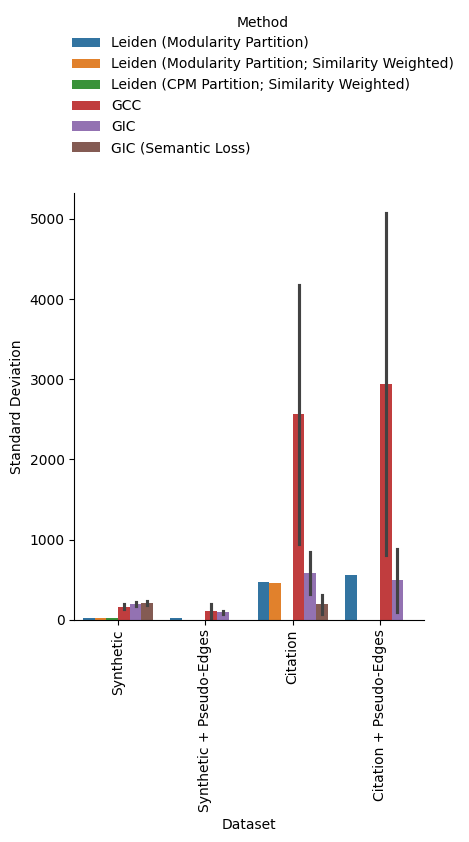

In [36]:
chkptsbydataset = {}

for chkpt in chkpts:
    if chkpt.dataset not in chkptsbydataset:
        chkptsbydataset[chkpt.dataset] = []
    chkptsbydataset[chkpt.dataset].append(chkpt)
data = {
    "min": [],
    "max": [],
    "Standard Deviation": [],
    "Method": [],
    "Dataset": []
}
for dataset in chkptsbydataset:
    x = []
    y = []
    label = []
    for chkpt in chkptsbydataset[dataset]:
        # if "CPM" in chkpt.algorithm:
        #     continue
        counts = np.array(list(Counter(chkpt.data).values()))
        dev = np.std(counts)
        n_clusters = len(counts)
        if n_clusters < 1000:
            data["min"].append(np.min(counts))
            data["max"].append(np.max(counts))
            data["Method"].append(chkpt.algorithm.replace("Undirected ", ""))
            data["Standard Deviation"].append(dev)
            data["Dataset"].append(dataset.value)
            x.append(n_clusters)
            y.append(dev)
            label.append(chkpt.algorithm)
    dataset_df = pd.DataFrame({
        "X": x,
        "Y": y,
        "Method": label,
    })
    print(dataset_df)
    # sns.scatterplot(x='X', y='Y', hue='Method', alpha=0.5, data=dataset_df)
    # plt.xlabel("Number of Clusters")
    # plt.ylabel("Standard Deviation")
    # plt.title(f"{dataset.value}")
    # plt.show()

    
df = pd.DataFrame(data)
g = sns.catplot(
    data=df, kind="bar",
    x="Dataset", y="Standard Deviation", hue="Method",
)
sns.move_legend(g, "upper center", bbox_to_anchor=(0.37, 1.35))
plt.xticks(rotation=90);


In [15]:
# def plot_cluster_sizes(title, clusters, sort=True):
#     categories = []
#     values = []
#     for k, v in Counter(clusters).items():
#         if sort:
#             categories.append(str(k))
#         else:
#             categories.append(k)
#         values.append(v)
#     if sort:
#         sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
#         categories = [categories[i] for i in sorted_indices]
#         values = [values[i] for i in sorted_indices]
#         plt.xticks([])
#     plt.bar(categories, values)
#     plt.title(title)
#     plt.xlabel("Cluster")
#     plt.ylabel("Cluster Size")
#     plt.show()
    
# # for chkpt in chkpts:
# #     title = f"{chkpt.dataset.value}: {chkpt.algorithm} ({chkpt.n_clusters} clusters)"
# #     plot_cluster_sizes(title, chkpt.data)